# Tool for the calculation of the mass balance gradient 

## Imports

In [2]:
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pandas as pd
from scipy import stats
import pylab

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

## Functions
Two functions, that eliminate nan from a given dataset

In [3]:
def filter_nan(data):
    return [x for x in data if str(x) != 'nan']

def clear_nan_hypso(hypso):
    hypso[0] = [ hypso[0][i] for i in range(0, len(hypso[0])) if str(hypso[1][i])!= 'nan' ]
    hypso[1]=[x for x in hypso[1] if str(x)!= 'nan']
    
    return hypso

returns the value of a linear function

In [4]:
def linear_function(slope, intercept, x):
    return x*slope + intercept


interpolates between the datapoints of a hypsometry. Choose 'linear' or 'cubic' as arguments for the kind

In [5]:
def interpolatad_hypso(x_data, y_data):
    return interp1d(x_data, y_data, kind='linear')



returns a renormed factor that represents the uncertainities of measurement points at given elevation


In [6]:
def transform_into_sigma(x):

    return 1/(np.sqrt(x))



fits the data without any weighting linearly

In [7]:
def fit(x_data_fit, x_data,y_data):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data,y_data)
    return ( slope, intercept, r_value, p_value, std_err)

combined linear fit: weighted and unweighted as well

In [8]:
def analyse(hypso, data, colour):
    
    # increase size
    plt.rcParams["figure.figsize"] = [15,10]
    
    
    #### The  hypsometry with interpolation #####
    # setting the x-values
    x_data_fit=np.linspace(np.min(data[0]),np.max(data[0]),1000)
    
    # plotting formalities
    plt.subplot(221)
    plt.title('Hypsometry of the glacier')
    plt.xlabel('Elevation [h]')
    plt.ylabel('relative_probability_density')
    plt.grid(True)
    
    # plot the data points
    plt.plot(hypso[0], hypso[1], 'bo', color=colour)
    
    # interpolation
    f1= interpolatad_hypso(hypso[0], hypso[1])
    x_inter=np.linspace(np.min(hypso[0]),np.max(hypso[0]),100)
    plt.plot(x_inter, f1(x_inter), color=colour)

    
    #### plot of relative weightening uncertainities #### 
    
    # plotting formalities
    plt.subplot(223)
    plt.title('Assumed uncertainities')
    plt.xlabel('Elevation [h]')
    plt.ylabel('relative uncertainity')
    plt.grid(True)
    
    # weightening uncertainities
    sigma=transform_into_sigma(f1(data[0]))
    
    # plot the sigma data points
    plt.plot(data[0], sigma, 'bo',color=colour)

    
    #### The actual data and fit ####
    popt, pcov = curve_fit(linear_function, data[0], data[1], sigma=sigma, absolute_sigma=False)

    yfit = [linear_function(popt[1], popt[0], i) for i in data[0]]
    
    # label stuff
    plt.subplot(222)
    plt.title('Data and the two fit curves')
    plt.xlabel('Elevation [m a.s.l.]')
    plt.ylabel('Mass balance [m w.e.]')
    plt.grid(True)
    
    # lines and data points
    plt.plot(data[0], yfit, label='weighted fit', color=colour)
    plt.plot(data[0],data[1],marker='o', linestyle='', color=colour)
    
    unweighted_fit=fit(x_data_fit, data[0],data[1])
    line=unweighted_fit[0]*x_data_fit + unweighted_fit[1]
    plt.plot(x_data_fit, line, linestyle='--', color=colour, label='unweighted fit')
    
    
    #### comparison between the gradients ####
    
    aha = plt.subplot(224)
    plt.title('Both gradients in comparison')
    axes = plt.axes(aha)
    axes.set_xticks([0,1])
    axes.set_xticklabels(['unweighted fit', 'weighted fit'], rotation='horizontal')
    plt.ylabel('gradient')
    plt.bar([0,1], [unweighted_fit[0], popt[1]], align='center',color=colour, yerr=[unweighted_fit[4],np.sqrt(np.diag(pcov))[1]])
    
    print('The MB-gradient (unweighted) is: ', unweighted_fit[0], ' +- ', unweighted_fit[4] ,'\n The MB-gradient (weighted) is: ', popt[1]  ,' +- ' , np.sqrt(np.diag(pcov))[1]   )
    
    
    plt.show()

## Main procedure

Read the data points from csv-file (best way to do it, is using pandas)

In [9]:
data_table = pd.read_csv('all_points.csv')

# if you want to take a look at what is read, remove comment of:
# print(data_table)

okay, lets put the data in glacier_specific arrays of the structure: (list with elevation data, list with MB data)

In [10]:
conrad_data = [filter_nan(data_table.iloc[ :,0].tolist()),filter_nan(data_table.iloc[ :,1].tolist())]
zillmer_data = [filter_nan(data_table.iloc[ :,9].tolist()),filter_nan(data_table.iloc[ :,10].tolist())]
nordic_data = [filter_nan(data_table.iloc[ :,6].tolist()),filter_nan(data_table.iloc[ :,7].tolist())]
kokanee_data = [filter_nan(data_table.iloc[ :,3].tolist()),filter_nan(data_table.iloc[ :,4].tolist())]
ille_data = [filter_nan(data_table.iloc[ :,12].tolist()),filter_nan(data_table.iloc[ :,13].tolist())]
castle_data = [filter_nan(data_table.iloc[ :,15].tolist()),filter_nan(data_table.iloc[ :,16].tolist())]

# check the number of data points in each glacier-specific array

print('Number of Data-points: \n Conrad: ', len(conrad_data[0]), '\n Zillmer: ', len(zillmer_data[0]),'\n Nordic: ', len(nordic_data[0]),'\n Kokanee: ', len(kokanee_data[0]),'\n Ille: ', len(ille_data[0]), '\n Castle: ', len(castle_data[0]))

Number of Data-points: 
 Conrad:  116 
 Zillmer:  104 
 Nordic:  68 
 Kokanee:  98 
 Ille:  78 
 Castle:  100


we combine all data for the last plot

In [11]:
combined_x_data=conrad_data[0]+zillmer_data[0]+nordic_data[0]+kokanee_data[0]+ille_data[0]+castle_data[0]
combined_y_data=conrad_data[1]+zillmer_data[1]+nordic_data[1]+kokanee_data[1]+ille_data[1]+castle_data[1]

#w/o illec data ---illec SMB lacks measurements over upper 200 m of glacier range, thus potentially biasing SMB grad.
combined_x_data2=conrad_data[0]+zillmer_data[0]+nordic_data[0]+kokanee_data[0]
combined_y_data2=conrad_data[1]+zillmer_data[1]+nordic_data[1]+kokanee_data[1]

#w/o castle
combined_x_data3=conrad_data[0]+zillmer_data[0]+nordic_data[0]+kokanee_data[0]+ille_data[0]
combined_y_data3=conrad_data[1]+zillmer_data[1]+nordic_data[1]+kokanee_data[1]+ille_data[1]


# filter 'nan' (otherwise we get a lot of errors)
combined_x_data=[x for x in combined_x_data if str(x) != 'nan']
combined_y_data=[x for x in combined_y_data if str(x) != 'nan']

#w/o illec data
combined_x_data=[x for x in combined_x_data if str(x) != 'nan']
combined_y_data=[x for x in combined_y_data if str(x) != 'nan']

## The actual analysis

We start with getting the hypsometries from the csv-file and make plottable datapoints out of them

In [12]:
hypso = pd.read_csv('hypsometry_study_glaciers.csv')

hypso_conrad= clear_nan_hypso([hypso.iloc[ :,1].tolist(),hypso.iloc[ :,2].tolist()])
hypso_zillmer= clear_nan_hypso([hypso.iloc[ :,1].tolist(),hypso.iloc[ :,3].tolist()])
hypso_nordic= clear_nan_hypso([hypso.iloc[ :,1].tolist(),hypso.iloc[ :,4].tolist()])
hypso_kokanee= clear_nan_hypso([hypso.iloc[ :,1].tolist(),hypso.iloc[ :,6].tolist()])
hypso_ille= clear_nan_hypso([hypso.iloc[ :,1].tolist(),hypso.iloc[ :,7].tolist()])
hypso_castle= clear_nan_hypso([hypso.iloc[ :,1].tolist(),hypso.iloc[ :,8].tolist()])

### Conrad glacier

The MB-gradient (unweighted) is:  0.007107081195808219  +-  0.00028684428320843535 
 The MB-gradient (weighted) is:  0.006829479800921194  +-  0.000330441567908487


/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


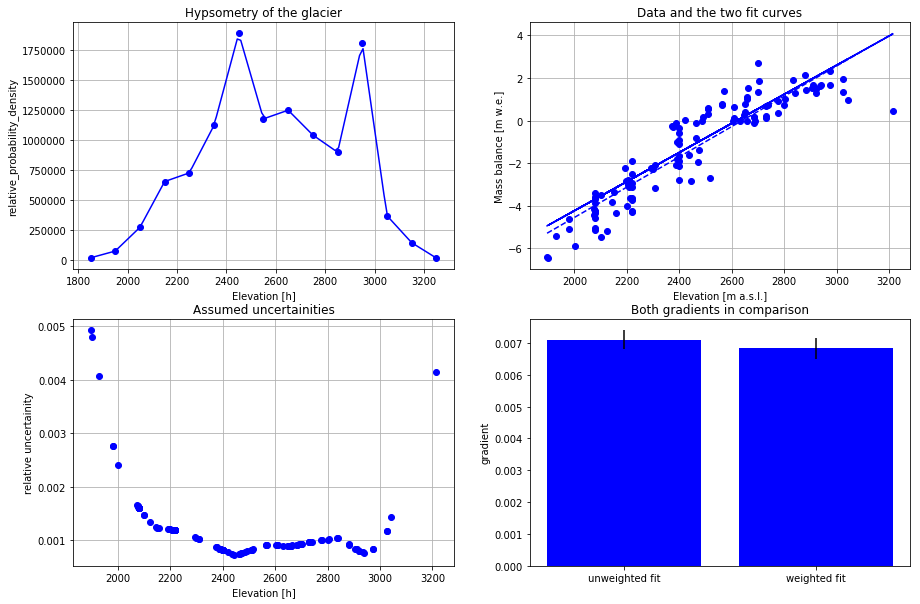

In [13]:
analyse(hypso_conrad, conrad_data, 'blue')

### Zillmer glacier

The MB-gradient (unweighted) is:  0.007921875952773941  +-  0.00046821222642323804 
 The MB-gradient (weighted) is:  0.008690488840119474  +-  0.0005486950642815271


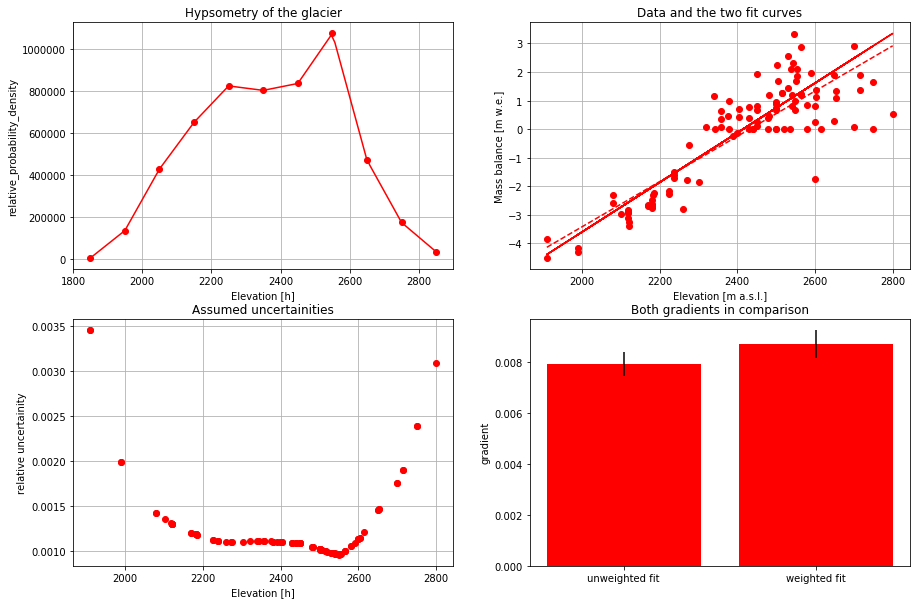

In [14]:
analyse(hypso_zillmer, zillmer_data, 'red')


### Nordic glacier

The MB-gradient (unweighted) is:  0.0060100833955718  +-  0.0006621869252084585 
 The MB-gradient (weighted) is:  0.005544449960942486  +-  0.0007540037903002107


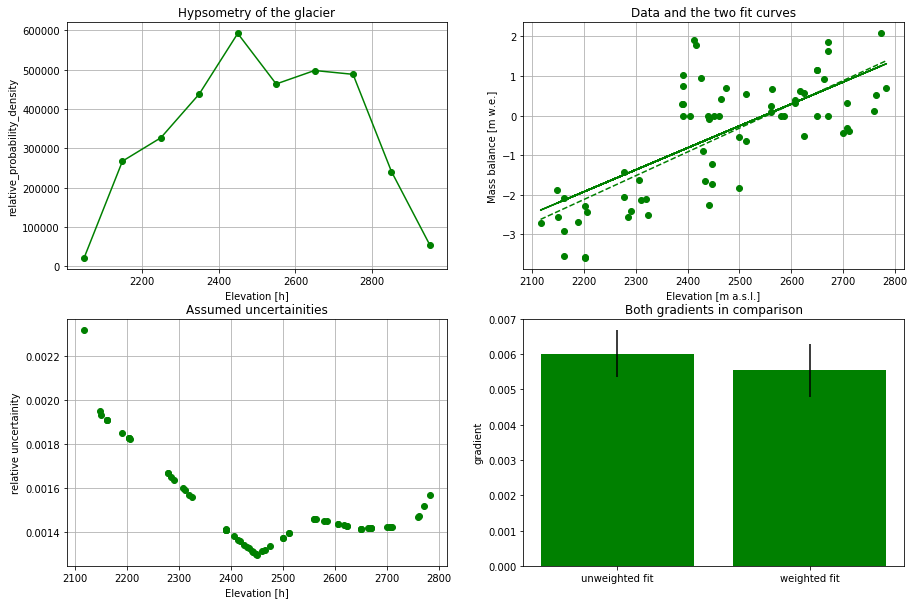

In [15]:
analyse(hypso_nordic, nordic_data, 'green')

### Kokanee glacier

The MB-gradient (unweighted) is:  0.006844988534209176  +-  0.0006108173921731677 
 The MB-gradient (weighted) is:  0.006239063894285832  +-  0.0007456875300378955


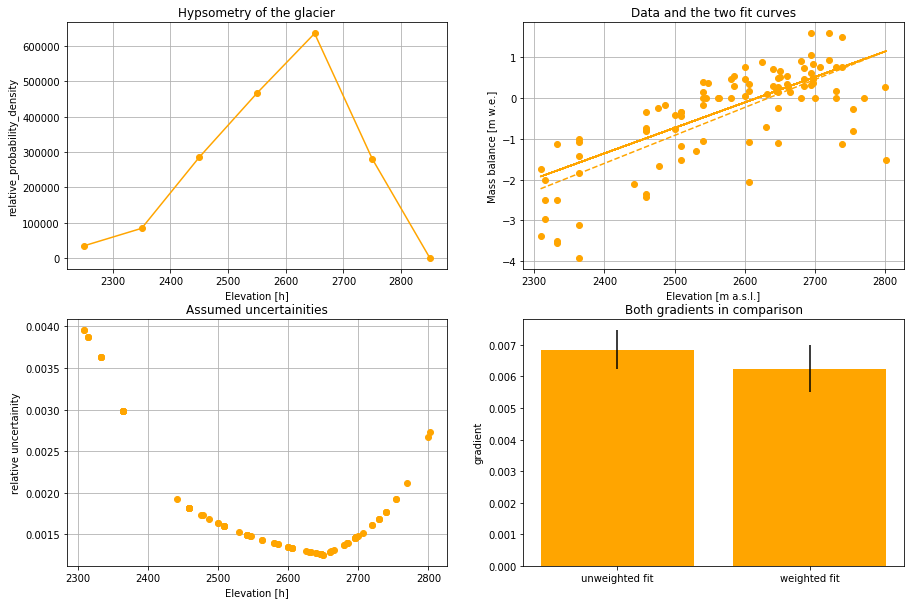

In [16]:
analyse(hypso_kokanee, kokanee_data, 'orange')

### Illecilewaet Glacier 

The MB-gradient (unweighted) is:  0.010849280869807123  +-  0.0005905659472440041 
 The MB-gradient (weighted) is:  0.010259301395477595  +-  0.0008829697163053981


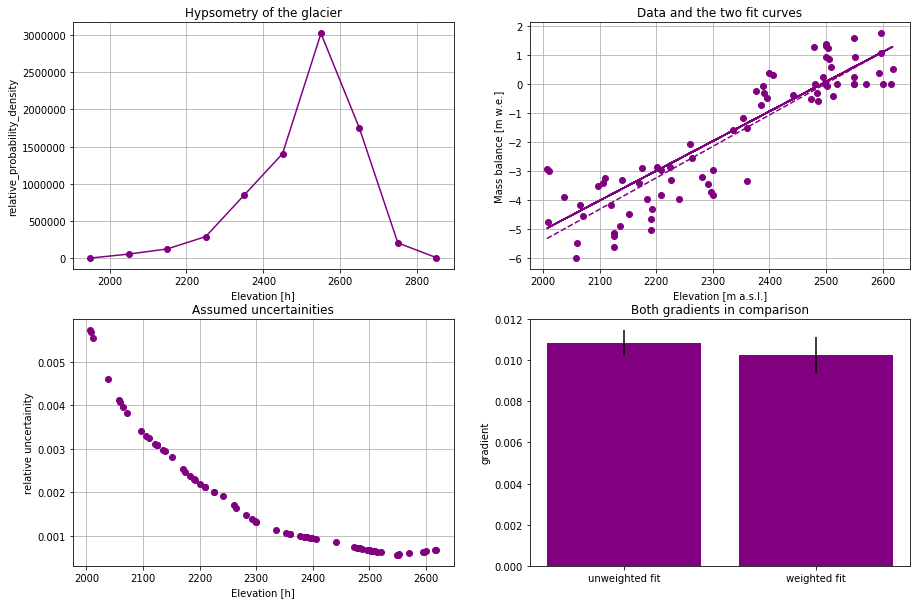

In [17]:
analyse(hypso_ille, ille_data, 'purple')

The MB-gradient (unweighted) is:  0.007188315940961024  +-  0.0002466356102654803 
 The MB-gradient (weighted) is:  0.0067531943269702605  +-  0.0003369141162644035


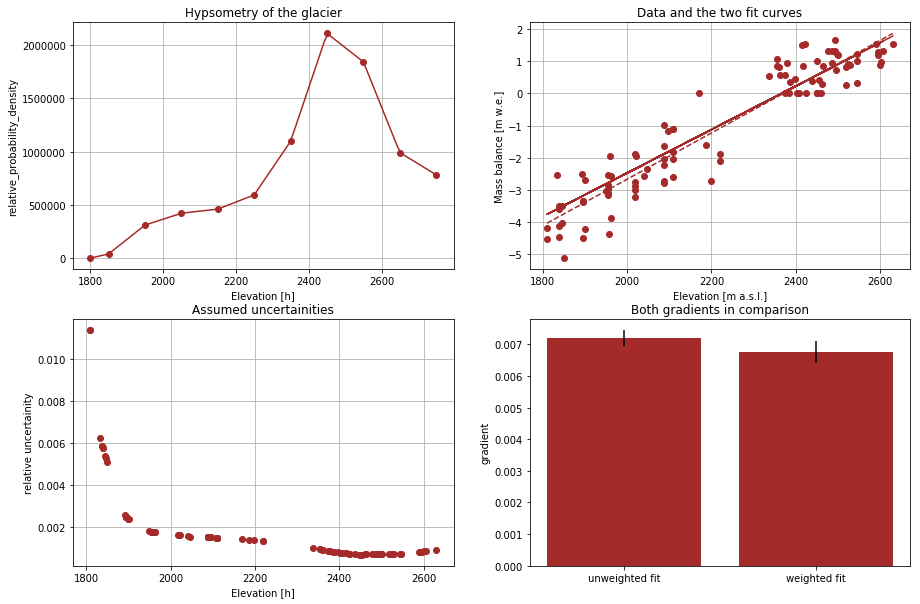

In [18]:
analyse(hypso_castle, castle_data, 'brown')

## Total plot with unweighted fit

not much physical basis for weighting in the manner tried above

the net gradient is:            6.43  +/-  0.2 m w.e. m-1
the net gradient w/o illec is:  6.66  +/-  0.25 m w.e. m-1
the net gradient w/o castle is:  7.19  +/-  0.23 m w.e. m-1


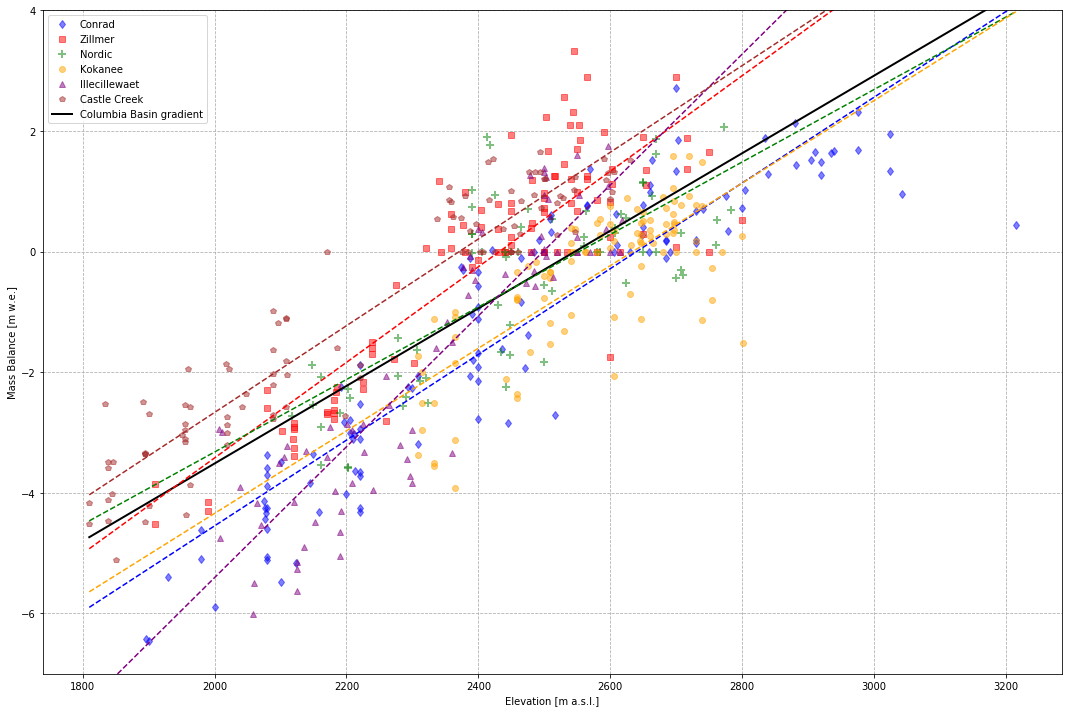

In [19]:
alpha = 0.5
plt.plot(conrad_data[0],conrad_data[1],marker='d', linestyle='', color='blue', label='Conrad', alpha=alpha)
plt.plot(zillmer_data[0],zillmer_data[1],marker='s', linestyle='', color='red', label='Zillmer', alpha=alpha)
plt.plot(nordic_data[0],nordic_data[1],marker='+', markersize=8., markeredgewidth=2., linestyle='', color='green', label='Nordic', alpha=alpha)
plt.plot(kokanee_data[0],kokanee_data[1],marker='o', linestyle='', color='orange', label='Kokanee', alpha=alpha)
plt.plot(ille_data[0],ille_data[1],marker='^', linestyle='', color='purple', label='Illecillewaet', alpha=alpha)
plt.plot(castle_data[0],castle_data[1],marker='p', linestyle='', color='brown', label='Castle Creek', alpha=alpha)

x_data_fit=np.linspace(np.min(combined_x_data),np.max(combined_x_data),1000)
x_data_fit2=np.linspace(np.min(combined_x_data2),np.max(combined_x_data2),1000)
x_data_fit3=np.linspace(np.min(combined_x_data3),np.max(combined_x_data3),1000)


print('the net gradient is:           ', np.round(fit(x_data_fit, combined_x_data,combined_y_data)[0]*1000,2) ,' +/- ' , np.round(fit(x_data_fit, combined_x_data,combined_y_data)[4]*1000,2), 'm w.e. m-1')
print('the net gradient w/o illec is: ', np.round(fit(x_data_fit2, combined_x_data2,combined_y_data2)[0]*1000,2) ,' +/- ' , np.round(fit(x_data_fit2, combined_x_data2,combined_y_data2)[4]*1000,2), 'm w.e. m-1')
print('the net gradient w/o castle is: ', np.round(fit(x_data_fit3, combined_x_data3,combined_y_data3)[0]*1000,2) ,' +/- ' , np.round(fit(x_data_fit3, combined_x_data3,combined_y_data3)[4]*1000,2), 'm w.e. m-1')

#plot lines of best fit for all points
plt.plot(x_data_fit, linear_function(fit(x_data_fit, combined_x_data,combined_y_data)[0], fit(x_data_fit, combined_x_data,combined_y_data)[1], x_data_fit), color='black', linewidth=2., label='Columbia Basin gradient')
# plt.plot(x_data_fit2, linear_function(fit(x_data_fit2, combined_x_data2,combined_y_data2)[0], fit(x_data_fit2, combined_x_data2,combined_y_data2)[1], x_data_fit2), color='black', linewidth=2., label='CB less Illec.')
# plt.fill_between(x_data_fit, y-0.25, y+0.25)

#plot lines of best fit for individual glaciers
plt.plot(x_data_fit, linear_function(fit(x_data_fit, conrad_data[0],conrad_data[1])[0], fit(x_data_fit, conrad_data[0],conrad_data[1])[1], x_data_fit), color='blue', linestyle='--', linewidth=1.5)
plt.plot(x_data_fit, linear_function(fit(x_data_fit, zillmer_data[0], zillmer_data[1])[0], fit(x_data_fit, zillmer_data[0], zillmer_data[1])[1], x_data_fit), color='red', linestyle='--', linewidth=1.5)
plt.plot(x_data_fit, linear_function(fit(x_data_fit, nordic_data[0],nordic_data[1])[0], fit(x_data_fit, nordic_data[0],nordic_data[1])[1], x_data_fit), color='green',linestyle='--', linewidth=1.5)
plt.plot(x_data_fit, linear_function(fit(x_data_fit, kokanee_data[0],kokanee_data[1])[0], fit(x_data_fit, kokanee_data[0],kokanee_data[1])[1], x_data_fit), color='orange',linestyle='--', linewidth=1.5)
plt.plot(x_data_fit, linear_function(fit(x_data_fit, ille_data[0],ille_data[1])[0],fit(x_data_fit, ille_data[0],ille_data[1])[1], x_data_fit), color='purple',linestyle='--', linewidth=1.5)
plt.plot(x_data_fit, linear_function(fit(x_data_fit, castle_data[0],castle_data[1])[0],fit(x_data_fit, castle_data[0],castle_data[1])[1], x_data_fit), color='brown',linestyle='--', linewidth=1.5)

plt.ylim(-7,4)
plt.xlabel('Elevation [m a.s.l.]')
plt.ylabel('Mass Balance [m w.e.]')
plt.rcParams["figure.figsize"] = [7,5]
plt.tight_layout()
plt.legend()
plt.grid(True, linestyle='--')
plt.savefig('/home/pelto/Desktop/lidar_cbt_analysis/Ba/products/all_gradients.png', dpi=300)